In [163]:
#General imports
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib
from pathlib import Path
import h5py
import glob

import pandas as pd

#scipy's fourier stuff
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

In [169]:
#Set Data Directories and create iterator over 
# hdf5 files for train and test datasets....

#path to data
dataDir = "/Users/DavidRimel/Desktop/CMSE890/Project/projectData/"
test_file = "single_test_knee/singlecoil_test" #"knee_multicoil_test_v2.tar.gz"
train_file = "single_val_knee/singlecoil_val" #"multicoil_val.tar.gz"

def hdf5_iter(Dir):
    return glob.iglob(dataDir+Dir+'/*.h5')

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00017707173297391214, 'norm': 0.058663394182755665, 'patient_id': 'b2a82c7521fe2d4aebb627bbaae92a1916bf06e75cb374fc4187b0909e5c0e36'}
184
160
344
24


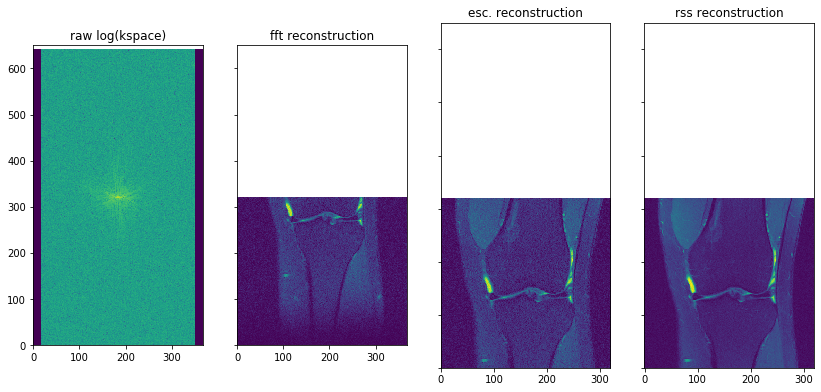

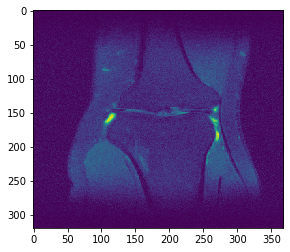

In [170]:
#Data Exploration just getting a sense of what features my data has...

test_file = "/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000000.h5"
hf = h5py.File(test_file)
volume_kspace = hf['kspace'][()]
slice_num = volume_kspace.shape[0]//2

hf = h5py.File(test_file)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]
volume_esc_recon = hf['reconstruction_esc'][()]
volume_rss_recon = hf['reconstruction_rss'][()]
del_img=volume_rss_recon.shape[2]//2

fig, ax = plt.subplots(1, 4, sharey=True,figsize=(14,14))
ax[0].imshow(np.log(np.abs(volume_kspace[slice_num])+1e-9))
ax[0].set_title("raw log(kspace)")
ax[0].set_ylim(0,650)
s_ksp = volume_kspace[slice_num]
s_ksp1 = ifftshift(ifft2(s_ksp))
c = (s_ksp1.shape[1]//2)
print(c)
print(del_img)
print(c+del_img)
print(c-del_img)
ax[1].imshow(np.abs(s_ksp1)[c-del_img:c+del_img,:])
ax[1].set_title("fft reconstruction")
ax[2].imshow(volume_esc_recon[slice_num])
ax[2].set_title("esc. reconstruction")
ax[3].imshow(volume_rss_recon[slice_num])
ax[3].set_title("rss reconstruction")
plt.show()

st_ksp = volume_kspace[slice_num]
st_ksp1 = ifftshift(ifft2(s_ksp[24:344,:]))
plt.imshow(np.abs(st_ksp1))

In [182]:
# Sort Train data into pandas DataFrames

hf = h5py.File("/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_train_knee/singlecoil_train/file1000001.h5")
volume_kspace = hf['kspace'][()]
train_shape = volume_kspace.shape
slice_num = train_shape[0]//2 #middle slice..

df_ksp = []
df_fftskp = []
df_truth = []

for h5 in hdf5_iter(train_file):
    
    print(h5)
    
    hf = h5py.File(h5)
    
    #for some reason one of the files is missing this attribute so just skip it...
    if ('kspace'  in hf.keys() ) and ('reconstruction_esc'  in hf.keys()) and ('reconstruction_rss' in hf.keys()):
    
        #grab slice by the slice num found above and flatten
        volume_kspace = hf['kspace'][()]
        #volume_esc_recon = hf['reconstruction_esc'][()]
        volume_rss_recon = hf['reconstruction_rss'][()]
        slice_kspace = volume_kspace[slice_num]
        slice_esc_recon = np.abs(ifftshift(ifft2(volume_kspace[slice_num])))
        slice_rss_recon = volume_rss_recon[slice_num]
        kspace_row = slice_kspace.flatten() 
        esc_row = slice_esc_recon.flatten() 
        rss_row = slice_rss_recon.flatten() 
    
        #add to List for dictionary
        df_ksp.append(kspace_row)
        df_fftskp.append(esc_row)
        df_truth.append(rss_row)
    
    
    hf.close()
    

X_dict = {"kspace freq":df_ksp,"FFT(kspace) real":df_fftskp}
y_dict = {"Ground Truth real":df_truth}
X_df = pd.DataFrame(data=X_dict)
y_df = pd.DataFrame(data=y_dict)

/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000000.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000007.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000017.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000026.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000031.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000033.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000041.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000052.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000071.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000073.h5


In [183]:
print(X_df.iloc[3,:])
print(y_df.iloc[3,:])

kspace freq         [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0...
FFT(kspace) real    [7.2245547e-09, 4.755277e-09, 5.4990656e-09, 4...
Name: 3, dtype: object
Ground Truth real    [1.0965071e-05, 1.8318073e-05, 1.0388026e-05, ...
Name: 3, dtype: object
